In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir_path = "/kaggle/input/face-expression-recognition-dataset/images/train"
valid_dir_path = "/kaggle/input/face-expression-recognition-dataset/images/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir_path,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'
)

validation_generator = valid_datagen.flow_from_directory(
    directory=valid_dir_path,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 23060 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
# Define the attentional CNN model
inputs = Input((48,48,1))

# Convolutional block 1
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional block 2
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Convolutional block 3
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Attention mechanism
attention = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)
x = Multiply()([x, attention])

# Fully-connected layers
x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(7, activation='softmax')(x)

In [5]:
# Define the model
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

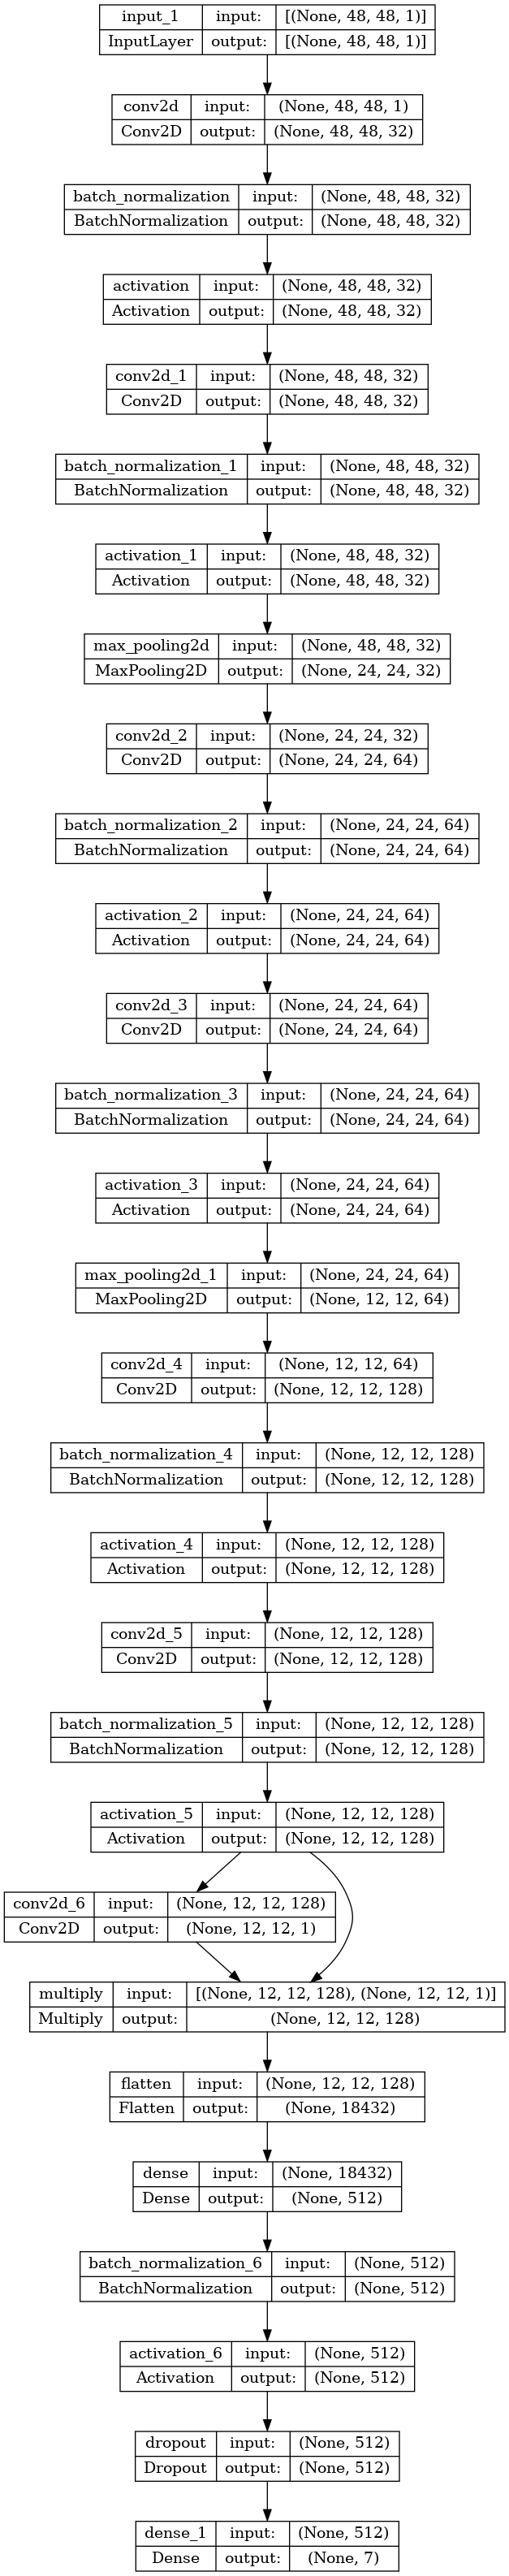

In [7]:
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/attentional_cnn.png', show_shapes=True)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint('/kaggle/working/best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.001)

In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the data generator
history = model.fit(train_generator,
          steps_per_epoch=train_generator.samples // train_generator.batch_size,
          epochs=60,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // validation_generator.batch_size,
          callbacks = [checkpoint, reduce_lr])

Epoch 1/60
360/360 [==============================] - ETA: 0s - loss: 1.8174 - accuracy: 0.3401
Epoch 1: val_accuracy improved from -inf to 0.36918, saving model to /kaggle/working/best_model_weights.h5
360/360 [==============================] - 166s 431ms/step - loss: 1.8174 - accuracy: 0.3401 - val_loss: 1.6459 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 2/60
360/360 [==============================] - ETA: 0s - loss: 1.4310 - accuracy: 0.4526
Epoch 2: val_accuracy improved from 0.36918 to 0.49276, saving model to /kaggle/working/best_model_weights.h5
360/360 [==============================] - 36s 101ms/step - loss: 1.4310 - accuracy: 0.4526 - val_loss: 1.3271 - val_accuracy: 0.4928 - lr: 0.0010
Epoch 3/60
360/360 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.5184
Epoch 3: val_accuracy improved from 0.49276 to 0.53111, saving model to /kaggle/working/best_model_weights.h5
360/360 [==============================] - 36s 100ms/step - loss: 1.2663 - accuracy: 0.518

In [66]:
model.load_weights('/kaggle/working/best_model_weights.h5')

# Fine-tune the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // train_generator.batch_size,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // validation_generator.batch_size,
          callbacks = [checkpoint])

Epoch 1/20
360/360 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8773
Epoch 1: val_accuracy did not improve from 0.65128
360/360 [==============================] - 38s 106ms/step - loss: 0.3389 - accuracy: 0.8773 - val_loss: 1.5463 - val_accuracy: 0.6442
Epoch 2/20
360/360 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.8812
Epoch 2: val_accuracy did not improve from 0.65128
360/360 [==============================] - 42s 116ms/step - loss: 0.3342 - accuracy: 0.8812 - val_loss: 1.4607 - val_accuracy: 0.6490
Epoch 3/20
360/360 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8865
Epoch 3: val_accuracy did not improve from 0.65128
360/360 [==============================] - 42s 117ms/step - loss: 0.3208 - accuracy: 0.8865 - val_loss: 1.5389 - val_accuracy: 0.6483
Epoch 4/20
360/360 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.8883
Epoch 4: val_accuracy did not improve from 0.65128
360/360 [=

In [8]:
model.save("/kaggle/working/attentional_model.h5")

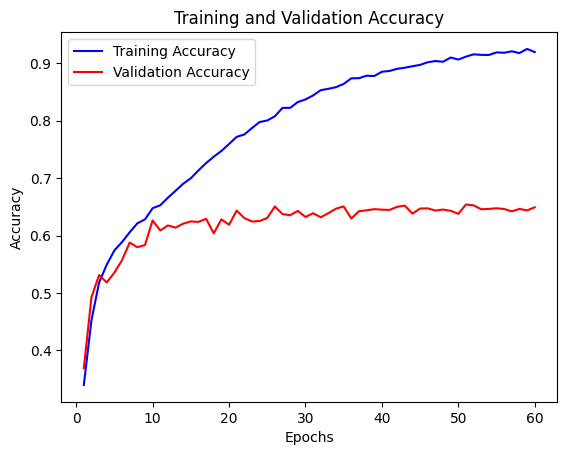

In [9]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy curve
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/kaggle/working/accuracy_cnn.png')

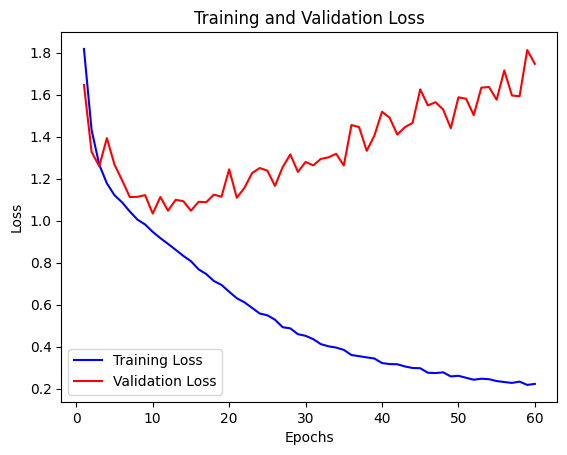

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_cnn.png')

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis = 1)

cm = confusion_matrix(validation_generator.classes, y_pred_classes)
labels = list(validation_generator.class_indices.keys())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Specify the save path and filename
save_path = '/kaggle/working//confusion_matrix.png'
plt.savefig(save_path)
plt.close()

111/111 [==============================] - 6s 50ms/step


In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = validation_generator.classes
report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices)
print()
print(report)

111/111 [==============================] - 7s 59ms/step

              precision    recall  f1-score   support

       angry       0.55      0.57      0.56       960
     disgust       0.79      0.55      0.65       111
        fear       0.54      0.42      0.47      1018
       happy       0.83      0.86      0.84      1825
     neutral       0.57      0.63      0.60      1216
         sad       0.52      0.52      0.52      1139
    surprise       0.76      0.77      0.76       797

    accuracy                           0.65      7066
   macro avg       0.65      0.62      0.63      7066
weighted avg       0.65      0.65      0.65      7066



In [48]:
import cv2
import numpy as np

image = cv2.imread('/kaggle/input/face-expression-recognition-dataset/images/validation/angry/10215.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
resized_image = cv2.resize(gray_image, (48, 48))
input_image = resized_image.reshape((1, 48, 48, 1))
input_image = input_image / 255.0

# Make a prediction using the model
prediction = model.predict(input_image)

# Get the class index with the highest probability
class_index = np.argmax(prediction[0])

# Print the predicted class label
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
class_label = class_labels[class_index]
print('Predicted class label:', class_label)

1/1 [==============================] - 0s 24ms/step
Predicted class label: Angry
